## Plant Disease Detection

## Author: Syed Abbas Ali

### Import necessary libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import warnings

# Ignore warning messages
warnings.filterwarnings('ignore')

### Data Preparation

In [2]:
# Set GPU device if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

data_dir = r'C:\Users\HP\OneDrive\Desktop\color'
input_size = (128, 128)  # Use a smaller image size
batch_size = 64

# Use data augmentation and rescale images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


### Model Definition

In [ ]:
# Load MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))  # Use MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


### Model Compilation and Training

In [3]:
# Enable mixed precision training
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

# Compile the model with the mixed precision optimizer
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Define a learning rate schedule to decrease learning rate during training
def lr_schedule(epoch):
    if epoch < 5:
        return 1e-4
    elif epoch < 10:
        return 1e-5
    else:
        return 1e-6

# Save the model checkpoints during training
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model for 10 epochs with learning rate scheduling and checkpoints
epochs = 10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[LearningRateScheduler(lr_schedule), checkpoint_callback]
)

Epoch 1/10
679/679 [==============================] - 3076s 4s/step - loss: 0.3215 - accuracy: 0.9129 - val_loss: 2.4360 - val_accuracy: 0.4377 - lr: 1.0000e-04
Epoch 2/10
679/679 [==============================] - 3502s 5s/step - loss: 0.0614 - accuracy: 0.9798 - val_loss: 1.2750 - val_accuracy: 0.6794 - lr: 1.0000e-04
Epoch 3/10
679/679 [==============================] - 3385s 5s/step - loss: 0.0390 - accuracy: 0.9874 - val_loss: 0.4530 - val_accuracy: 0.8772 - lr: 1.0000e-04
Epoch 4/10
679/679 [==============================] - 3038s 4s/step - loss: 0.0307 - accuracy: 0.9905 - val_loss: 0.2149 - val_accuracy: 0.9456 - lr: 1.0000e-04
Epoch 5/10
679/679 [==============================] - 3042s 4s/step - loss: 0.0299 - accuracy: 0.9901 - val_loss: 0.1909 - val_accuracy: 0.9477 - lr: 1.0000e-04
Epoch 6/10
679/679 [==============================] - 3628s 5s/step - loss: 0.0137 - accuracy: 0.9956 - val_loss: 0.0324 - val_accuracy: 0.9895 - lr: 1.0000e-05
Epoch 7/10
679/679 [==============

### Results Visualization and Model Evaluation

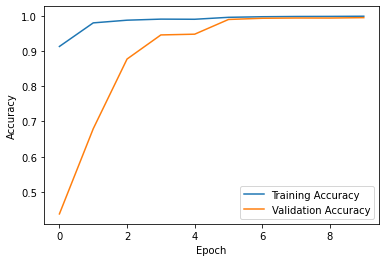

In [4]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

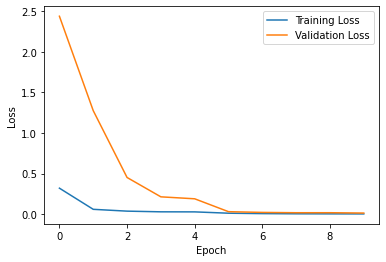

In [5]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
# Save the final model
model.save('mobilenetv2_color_model.h5')

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the ground truth labels and perform predictions
true_labels = test_generator.classes
pred_probs = model.predict(test_generator)
predicted_labels = np.argmax(pred_probs, axis=1)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices))

print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

Found 54305 images belonging to 38 classes.
849/849 [==============================] - 616s 725ms/step
Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.99      0.99       630
                                 Apple___Black_rot       1.00      1.00      1.00       621
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       275
                                   Apple___healthy       0.99      1.00      1.00      1645
                               Blueberry___healthy       1.00      1.00      1.00      1502
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99      1052
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       854
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.97      0.96       513
                       Corn_(maize)___Common_